In [0]:
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
import gym
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    
    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

In [0]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, action_std):
        super(ActorCritic, self).__init__()
        # action mean range -1 to 1
        self.actor =  nn.Sequential(
                nn.Linear(state_dim, 64),
                nn.Tanh(),
                nn.Linear(64, 32),
                nn.Tanh(),
                nn.Linear(32, action_dim),
                nn.Tanh()
                )
        # critic
        self.critic = nn.Sequential(
                nn.Linear(state_dim, 64),
                nn.Tanh(),
                nn.Linear(64, 32),
                nn.Tanh(),
                nn.Linear(32, 1)
                )
        self.action_var = torch.full((action_dim,), action_std*action_std).to(device)
        
    def forward(self):
        raise NotImplementedError
    
    def act(self, state, memory):
        action_mean = self.actor(state)
        cov_mat = torch.diag(self.action_var).to(device)
        
        dist = MultivariateNormal(action_mean, cov_mat)
        action = dist.sample()
        action_logprob = dist.log_prob(action)
        
        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(action_logprob)
        
        return action.detach()
    
    def evaluate(self, state, action):   
        action_mean = self.actor(state)
        
        action_var = self.action_var.expand_as(action_mean)
        cov_mat = torch.diag_embed(action_var).to(device)
        
        dist = MultivariateNormal(action_mean, cov_mat)
        
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_value = self.critic(state)
        
        return action_logprobs, torch.squeeze(state_value), dist_entropy


class ActorCriticLayerNorm(nn.Module):
    def __init__(self, state_dim, action_dim, action_std):
        super(ActorCriticLayerNorm, self).__init__()
        # action mean range -1 to 1
        self.actor =  nn.Sequential(
                nn.Linear(state_dim, 64),
                nn.LayerNorm(64),
                nn.Tanh(),

                nn.Linear(64, 32),
                nn.LayerNorm(32),
                nn.Tanh(),

                nn.Linear(32, action_dim),
                nn.Tanh()
                )
        # critic
        self.critic = nn.Sequential(
                nn.Linear(state_dim, 64),
                nn.Tanh(),
                nn.Linear(64, 32),
                nn.Tanh(),
                nn.Linear(32, 1)
                )
        self.action_var = torch.full((action_dim,), action_std*action_std).to(device)
        
    def forward(self):
        raise NotImplementedError
    
    def act(self, state, memory):
        action_mean = self.actor(state)
        cov_mat = torch.diag(self.action_var).to(device)
        
        dist = MultivariateNormal(action_mean, cov_mat)
        action = dist.sample()
        action_logprob = dist.log_prob(action)
        
        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(action_logprob)
        
        return action.detach()
    
    def evaluate(self, state, action):   
        action_mean = self.actor(state)
        
        action_var = self.action_var.expand_as(action_mean)
        cov_mat = torch.diag_embed(action_var).to(device)
        
        dist = MultivariateNormal(action_mean, cov_mat)
        
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_value = self.critic(state)
        
        return action_logprobs, torch.squeeze(state_value), dist_entropy

In [0]:
class PPO:
    def __init__(self,state_dim,action_dim,n_latent_var,K_epochs,parameter_noise):
        self.lr = 0.002
        self.betas = (0.9,0.999)
        self.gamma =0.99
        self.eps_clip = 0.2

        self.K_epochs = K_epochs

        self.mse_loss = nn.MSELoss()

        self.action_std = 0.5

        if parameter_noise:
            self.policy_new = ActorCriticLayerNorm(state_dim,action_dim,self.action_std).to(device)
            self.policy_old = ActorCriticLayerNorm(state_dim,action_dim,self.action_std).to(device)

        else:

            #we have 2 policies old and new
            self.policy_new = ActorCritic(state_dim,action_dim,self.action_std).to(device)
            self.policy_old = ActorCritic(state_dim,action_dim,self.action_std).to(device)

        self.optimizer = torch.optim.Adam(self.policy_new.parameters(),lr = self.lr,betas = self.betas)

        #synchronizing 2 neural networks in the beginning
        self.policy_old.load_state_dict(self.policy_new.state_dict())

    def select_action(self, state, memory):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.policy_old.act(state, memory).cpu().data.numpy().flatten()

    def update(self,memory):
        
        gamma = self.gamma
        #creating list of discounted rewards
        discounted_rewards = []
        discounted_reward = 0
        
        for reward, is_terminal in zip(reversed(memory.rewards),reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + gamma * discounted_reward
            discounted_rewards.append(discounted_reward)

        discounted_rewards = discounted_rewards[::-1]

        discounted_rewards = torch.tensor(discounted_rewards).to(device)
        #normalizing: mean = 0, std = 1
        discounted_rewards = (discounted_rewards - torch.mean(discounted_rewards))/(torch.std(discounted_rewards) + 1e-5)
        

        #creating tensor from list
        old_states = torch.stack(memory.states).to(device).detach()
        old_actions = torch.stack(memory.actions).to(device).detach()
        old_logprobs = torch.stack(memory.logprobs).to(device).detach()

        #gradient ascent for K epochs
        for i in range(self.K_epochs):

            logprobs, state_values, dist_entropy = self.policy_new.evaluate(old_states,old_actions)

            #calculating policy_new/policy_old ratio
            ratios = torch.exp(logprobs - old_logprobs.detach())

            #surrogate loss
            advantages = discounted_rewards - state_values

            #
            surr1 = advantages * ratios
            surr2 = torch.clamp(ratios,min=1-self.eps_clip,max = 1+self.eps_clip)*advantages

            loss = -torch.min(surr1,surr2) + 0.5 * self.mse_loss(discounted_rewards,state_values) - 0.01*dist_entropy

            #backprop
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()


        #new policy becomes old policy
        self.policy_old.load_state_dict(self.policy_new.state_dict())


In [0]:
def add_noise(policy, std):
    n_normalized_layers = 2
    noisy_layers=0
    for layer in policy.actor:
        if noisy_layers == n_normalized_layers:
            break
        if isinstance(layer,nn.Linear):
            #generating noise with given std
            noise = torch.normal(mean=0,std=std,size=(layer.weight.shape)).to(device)

            with torch.no_grad():
                layer.weight += noise
            noisy_layers += 1
    # we don't have to return anything because function modifies parameters in place

In [0]:
def main(parameter_noise=False):
    ############## Hyperparameters ##############
    env_name = "Pendulum-v0"
    render = False
    solved_reward = 300         # stop training if avg_reward > solved_reward
    log_interval = 100           # print avg reward in the interval
    max_episodes = 5000        # max training episodes
    max_timesteps = 200        # max timesteps in one episode
    
    update_timestep = 2000      # update policy every n timesteps
    action_std = 0.5            # constant std for action distribution (Multivariate Normal)
    K_epochs = 2               # update policy for K epochs
    eps_clip = 0.2              # clip parameter for PPO
    gamma = 0.99                # discount factor
    n_latent_var = 64
    lr = 0.0003                 # parameters for Adam optimizer
    betas = (0.9, 0.999)
    
    random_seed = None
    #############################################
    
    # creating environment
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    
    if random_seed:
        print("Random Seed: {}".format(random_seed))
        torch.manual_seed(random_seed)
        env.seed(random_seed)
        np.random.seed(random_seed)
    
    memory = Memory()
    ppo = PPO(state_dim, action_dim,n_latent_var, K_epochs,parameter_noise)
    print(lr,betas)
    
    # logging variables
    running_reward = 0
    avg_length = 0
    time_step = 0


    #parameter noise hyperparams
    sigma = 0.1
    distance_threshold = 0.2
    noise_scalefactor = 1.01
    perturbation_timestep = 4000

    rewards_plot = []
    

    # training loop
    for i_episode in range(1, max_episodes+1):
        state = env.reset()

        add_noise(ppo.policy_old,sigma)



        for t in range(max_timesteps):
            time_step +=1
            # Running policy_old:
            action = ppo.select_action(state, memory)
            state, reward, done, _ = env.step(action)
            
            # Saving reward and is_terminals:
            memory.rewards.append(reward)
            memory.is_terminals.append(done)
            

            if time_step % perturbation_timestep ==0 and parameter_noise:
                with torch.no_grad():
                    # print('parameter noise')
                    
                    policy_perturbed = ActorCriticLayerNorm(state_dim,action_dim,action_std).to(device)

                    policy_perturbed.load_state_dict(ppo.policy_old.state_dict())

                    add_noise(policy_perturbed, sigma)

                    states = torch.stack(memory.states).to(device).detach()

                                        #action means
                    out_original = ppo.policy_old.actor(states)
                    out_perturbed = policy_perturbed.actor(states)

                    distance = torch.mean(torch.sqrt((out_original - out_perturbed)**2))

                    if distance < distance_threshold:
                            # parameter_noise = [layer_noise * noise_scalefactor for layer_noise in parameter_noise]
                        sigma *= noise_scalefactor

                    elif distance > distance_threshold:
                            # parameter_noise = [layer_noise / noise_scalefactor for layer_noise in parameter_noise]
                        sigma /= noise_scalefactor

                    # ppo.policy_old.load_state_dict(policy_perturbed.state_dict())



            # update if its time
            if time_step % update_timestep == 0:
                # print('update')
                ppo.update(memory)
                memory.clear_memory()
                # time_step = 0
            running_reward += reward
            # rewards_plot.append(reward)
            if render:
                env.render()
            if done:
                break
        
        avg_length += t
        
        # stop training if avg_reward > solved_reward
        if running_reward > (log_interval*solved_reward):
            print("########## Solved! ##########")
            torch.save(ppo.policy.state_dict(), './PPO_continuous_solved_{}.pth'.format(env_name))
            break

        
            
        # logging
        if i_episode % log_interval == 0:
            avg_length = int(avg_length/log_interval)
            running_reward = int((running_reward/log_interval))
            rewards_plot.append(running_reward)
            
            print('Episode {} \t Avg length: {} \t Avg reward: {}'.format(i_episode, avg_length, running_reward))
            running_reward = 0
            avg_length = 0

    return rewards_plot

In [0]:
if __name__ == '__main__':
    rewards_noisy = main(parameter_noise=True)

In [12]:
rewards_nonoise = main(parameter_noise=False)

0.0003 (0.9, 0.999)
Episode 100 	 Avg length: 199 	 Avg reward: -1300
Episode 200 	 Avg length: 199 	 Avg reward: -1340
Episode 300 	 Avg length: 199 	 Avg reward: -1258
Episode 400 	 Avg length: 199 	 Avg reward: -1299
Episode 500 	 Avg length: 199 	 Avg reward: -1189
Episode 600 	 Avg length: 199 	 Avg reward: -1258
Episode 700 	 Avg length: 199 	 Avg reward: -1307
Episode 800 	 Avg length: 199 	 Avg reward: -1292
Episode 900 	 Avg length: 199 	 Avg reward: -1323
Episode 1000 	 Avg length: 199 	 Avg reward: -1374
Episode 1100 	 Avg length: 199 	 Avg reward: -1340
Episode 1200 	 Avg length: 199 	 Avg reward: -1263
Episode 1300 	 Avg length: 199 	 Avg reward: -1217
Episode 1400 	 Avg length: 199 	 Avg reward: -1254
Episode 1500 	 Avg length: 199 	 Avg reward: -1361
Episode 1600 	 Avg length: 199 	 Avg reward: -1329
Episode 1700 	 Avg length: 199 	 Avg reward: -1265
Episode 1800 	 Avg length: 199 	 Avg reward: -1330
Episode 1900 	 Avg length: 199 	 Avg reward: -1279
Episode 2000 	 Avg l

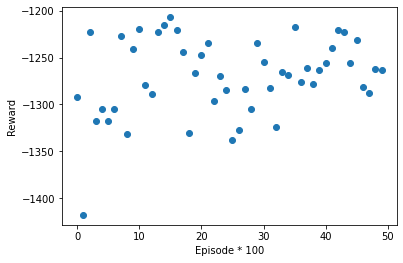

In [9]:
import matplotlib.pyplot as plt
t = np.arange(len(rewards_noisy))
plt.ylabel('Reward')
plt.xlabel("Episode * 100")
plt.scatter(t,rewards_noisy)

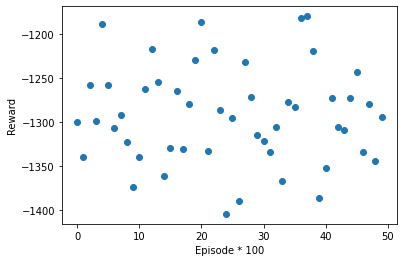

In [13]:
t = np.arange(len(rewards_nonoise))
plt.ylabel('Reward')
plt.xlabel("Episode * 100")
plt.scatter(t,rewards_nonoise)